# Example of ground-truth comparison with SpikeInterface

This notebook shows how [SpikeInterface](https://github.com/SpikeInterface) is used to perform a ground truth comparisong for multiple spike sorters.

The dataset is simulated using [MEArec](https://github.com/alejoe91/MEArec) and it can be downloaded from Zenodo: https://doi.org/10.5281/zenodo.4058272

The dataset name is: **recordings_50cells_SqMEA-10-15_600.0_10.0uV_21-01-2020_18-12.h5**. It contains 50 neurons recorded on a 10x10 MEA with 15um pitch. The duration is 600s and the noise level is 10uV.

Author: [Samuel Garcia](https://github.com/samuelgarcia), CRNL, Lyon

### Requirements

For this need you will need the following Python packages:

- numpy
- pandas
- matplotlib
- seaborn
- spikeinterface

To run the MATLAB-based sorters, you would also need a MATLAB license.
For other sorters, please refer to the documentation on [how to install sorters](https://spikeinterface.readthedocs.io/en/latest/sortersinfo.html).

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path


import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.sorters as ss
import spikeinterface.widgets as sw

from spikeinterface.comparison import GroundTruthStudy

/home/samuel/.virtualenvs/py36/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# clone and install MATLAB sorters

# kilosort2
!git clone https://github.com/MouseLand/Kilosort2.git
kilosort2_path = './Kilosort2'
ss.Kilosort2Sorter.set_kilosort2_path(kilosort2_path)

# kilosort
!git clone https://github.com/cortex-lab/KiloSort.git
kilosort_path = './KiloSort'
ss.KilosortSorter.set_kilosort_path(kilosort_path)

# ironclust
!git clone https://github.com/flatironinstitute/ironclust.git
ironclust_path = './ironclust'
ss.IronclustSorter.set_ironclust_path(ironclust_path)

In [35]:
%matplotlib inline

# some matplotlib hack to prettify figure
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', figsize=(10.0, 8.0))  # figsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def clear_axes(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)    

## Check spikeinterface version and sorter version

In order to be a bit reproducible lets checks for versions of each sorter and spikeinterface subpackage.


In [5]:
si.print_spikeinterface_version()
ss.print_sorter_versions()

spikeinterface: 0.9.1
  * spikeextractor: 0.7.1
  * spiketoolkit: 0.5.1
  * spikesorters: 0.2.4.dev0
  * spikecomparison: 0.2.2
  * spikewidgets: 0.3.2

herdingspikes: 0.3.3+git.f5232ac3520d
ironclust: 5.7.3
kilosort: git-cd040da1963d
kilosort2: git-67a42a87b866
klusta: 3.0.16
mountainsort4: unknown
spykingcircus: 0.9.2
tridesclous: 1.5.0


## Setup global path

In [6]:
# Change this path to point to where you downloaded the dataset
p = Path('/home/samuel/Documents/DataSpikeSorting/mearec/')
study_folder = p / 'study_mearec_SqMEA1015um/'

## Setup ground truth study

In [10]:
# lets load from mearec file the recording (traces) and the true sorting (spiketrains and units)
mearec_filename = p / 'recordings_50cells_SqMEA-10-15_600.0_10.0uV_21-01-2020_18-12.h5'
rec0  = se.MEArecRecordingExtractor(mearec_filename)
gt_sorting0 = se.MEArecSortingExtractor(mearec_filename)

# a study can have several pari of recording/GT sorting
# here we have only one
gt_dict = {'rec0' : (rec0, gt_sorting0) }

study = GroundTruthStudy.create(study_folder, gt_dict)

## Run all sorters

In [13]:
sorter_list = ['herdingspikes', 'ironclust', 'kilosort2',  'kilosort',
                'spykingcircus', 'tridesclous'] # 

In [ ]:
study = GroundTruthStudy(study_folder)

# here we will take default params for each sorter engine
# but we could change it
sorter_params = {} 

study.run_sorters(sorter_list, sorter_params=sorter_params, mode='keep', verbose=True)

## Get signal to noise ratio for all units

In [7]:
study = GroundTruthStudy(study_folder)
snr = study.get_units_snr()
snr.head(10)

snr rec_name
gt_unit_id                    
0            5.837606     rec0
1            6.735090     rec0
2            7.249846     rec0
3           21.647741     rec0
4           10.273477     rec0
5           15.612622     rec0
6           13.773396     rec0
7            9.518503     rec0
8           12.626004     rec0
9            6.680142     rec0

Text(0.5, 0, 'GT units SNR')

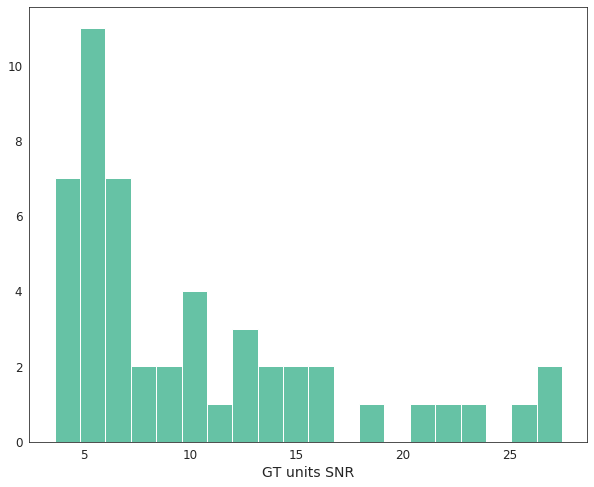

In [36]:
fig, ax = plt.subplots()
ax.hist(snr['snr'].values, bins=20)
ax.set_xlabel('GT units SNR')

## Run comparison with ground truth and retreive result tables

In [9]:
# this copy sorting is necessary to copy results from sorter
# into a centralize folder with all results
study.copy_sortings()

# this run all comparison sto GT
study.run_comparisons(exhaustive_gt=True, match_score=0.1, overmerged_score=0.2)

In [10]:
# this retrieve results
comparisons = study.comparisons
dataframes = study.aggregate_dataframes()

## Run times

In [11]:
dataframes['run_times']

rec_name    sorter_name    run_time
0     rec0       kilosort  359.392333
1     rec0  spykingcircus  742.992190
2     rec0  herdingspikes  148.370694
3     rec0      ironclust  128.119042
4     rec0      kilosort2  148.978660
5     rec0    tridesclous  616.314811

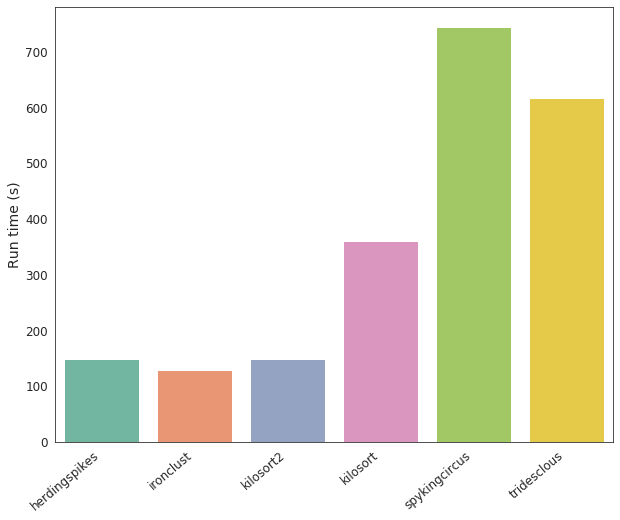

In [37]:
fig, ax = plt.subplots()
sns.barplot(data=dataframes['run_times'], x='sorter_name', y='run_time', ax=ax, order=sorter_list)

sns.set_palette(sns.color_palette("Set1"))
ax.set_ylabel('Run time (s)');
ax.set_xlabel(None);
ax.set_xticklabels(sorter_list, rotation=40, ha='right');

## confusion matrix

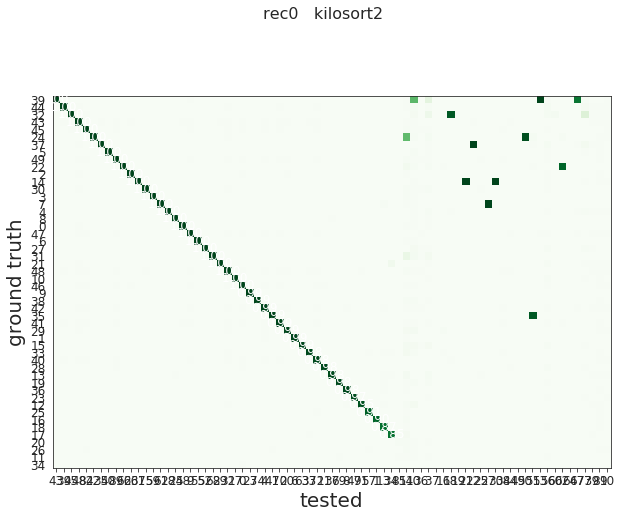

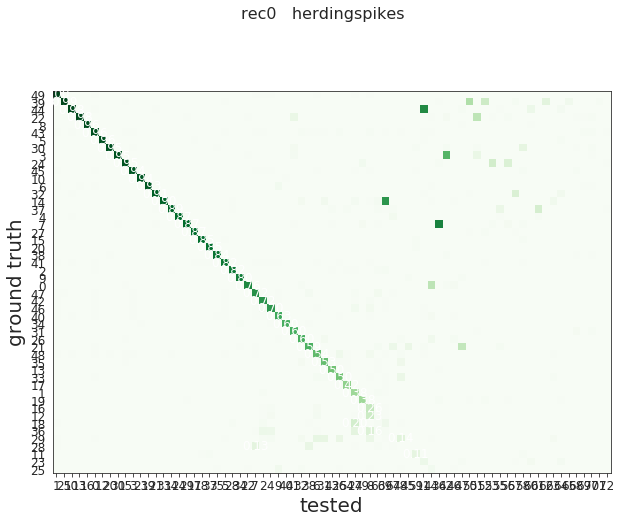

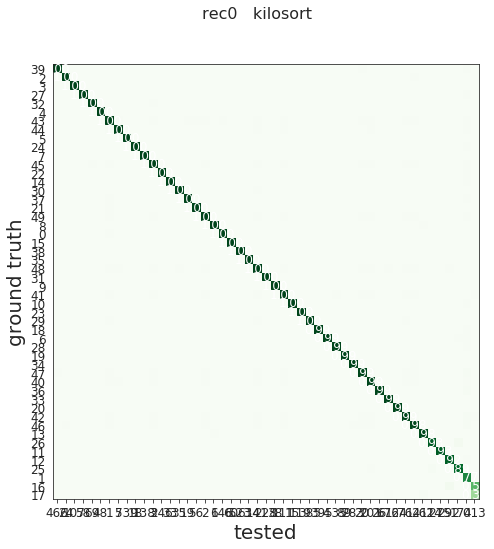

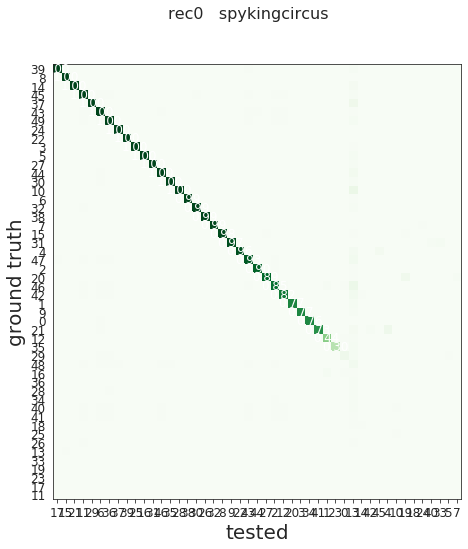

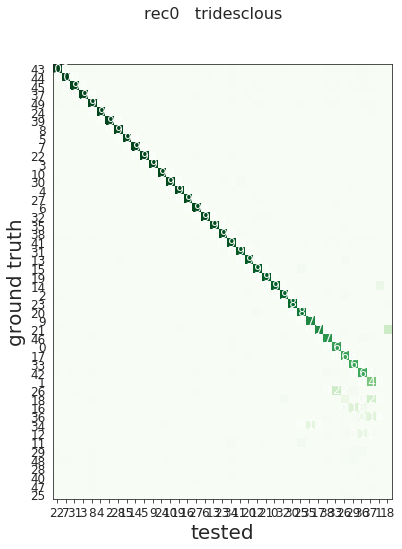

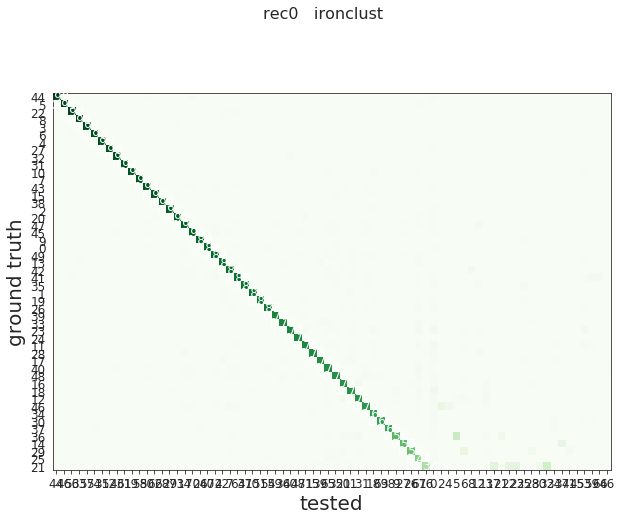

In [38]:
for (rec_name, sorter_name), comp in comparisons.items():
    fig, ax = plt.subplots()
    sw.plot_agreement_matrix(comp, ax=ax)
    fig.suptitle(rec_name+'   '+ sorter_name)

## accuracy/precision/recall scores per sorters

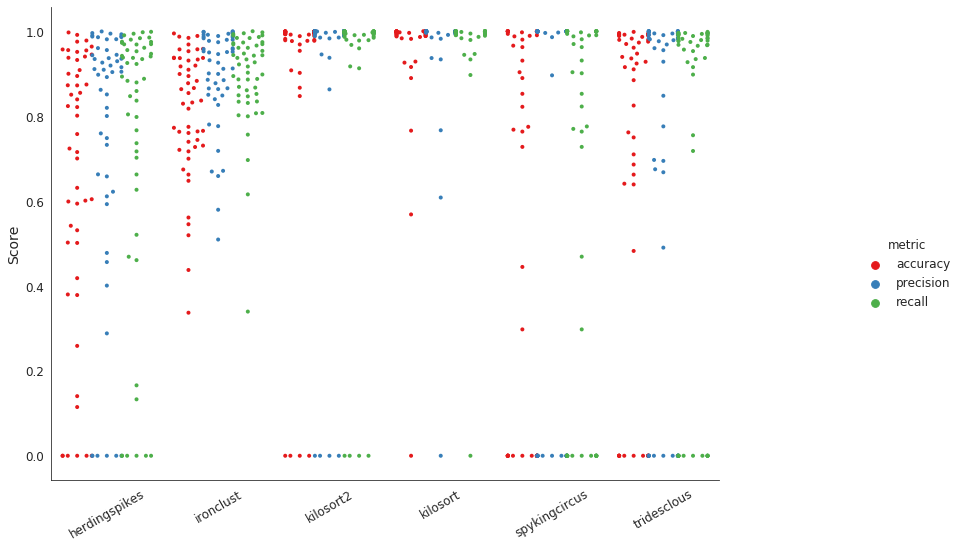

In [44]:

sns.set_palette(sns.color_palette("Set1"))

df = pd.melt(dataframes['perf_by_units'], id_vars='sorter_name', var_name='metric', value_name='score', 
        value_vars=('accuracy','precision', 'recall'))

g = sns.catplot(data=df, x='sorter_name', y='score', hue='metric', kind='swarm', dodge=True,
                order=sorter_list, legend_out=True, s=4)
g.fig.set_size_inches(15,8)
ax = g.axes[0, 0]
#ax.legend(['Accuracy', 'Precision', 'Recall'], labelspacing=0.2,
#          bbox_to_anchor=(1, 0.5), loc=2, borderaxespad=0., frameon=False)
ax.set_xticklabels(sorter_list, rotation=30, ha='center')
ax.set_xlabel(None)
ax.set_ylabel('Score')
clear_axes(ax)

A wise man (a reviewer of our paper to be honest) suggest us that the swarnplot is not so infortative to benchmark sorters.
This is totally true, we can check check the balance between false postive spikes and and false negative spikes (precission vs recall).
Here this is another possible way to present the results.

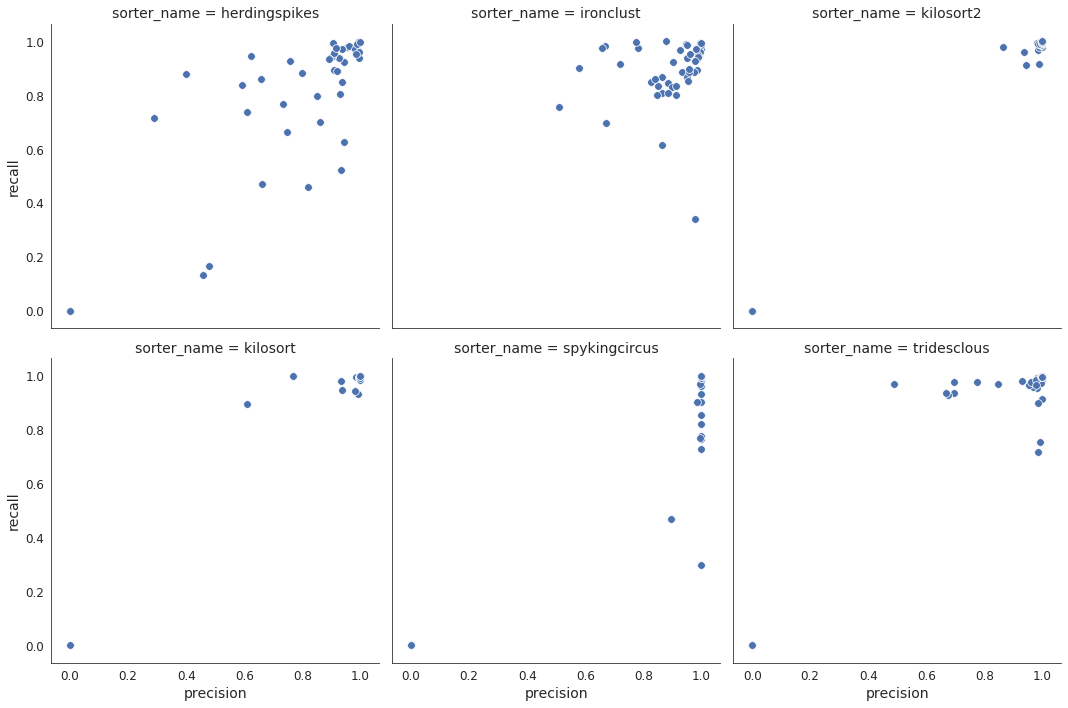

In [21]:
sns.set_palette(sns.color_palette("deep"))
g = sns.relplot(data=dataframes['perf_by_units'], x='precision', y='recall', col='sorter_name', 
                col_wrap=3, col_order=sorter_list, s=60)

## count units

  * well detected
  * false positive
  * redundant
  * overmerged

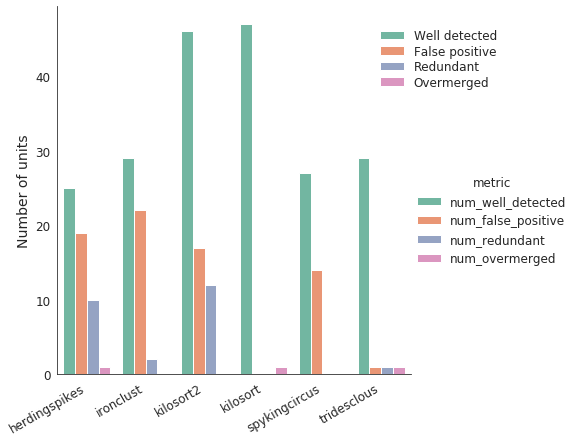

In [34]:

sns.set_palette(sns.color_palette("Set2"))

df = pd.melt(dataframes['count_units'], id_vars='sorter_name', var_name='metric', value_name='score', 
        value_vars=('num_well_detected', 'num_false_positive', 'num_redundant', 'num_overmerged'))
g = sns.catplot(x='sorter_name', y='score', hue='metric', data=df,
                height=6, kind="bar", order=sorter_list)

ax = g.axes[0,0]
ax.set_xticklabels(sorter_list, rotation=30, ha='right')

ax.get_legend()
ax.legend(bbox_to_anchor=(0.9, 0.95), borderaxespad=0., frameon=False, labelspacing=0.2)
for t, l in zip(ax.legend_.texts,("Well detected", "False positive", "Redundant", "Overmerged")):
    t.set_text(l)


ax.set_xlabel(None)
ax.set_ylabel('Number of units')
clear_axes(ax)

## Accuracy vns SNR

/home/samuel/.virtualenvs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


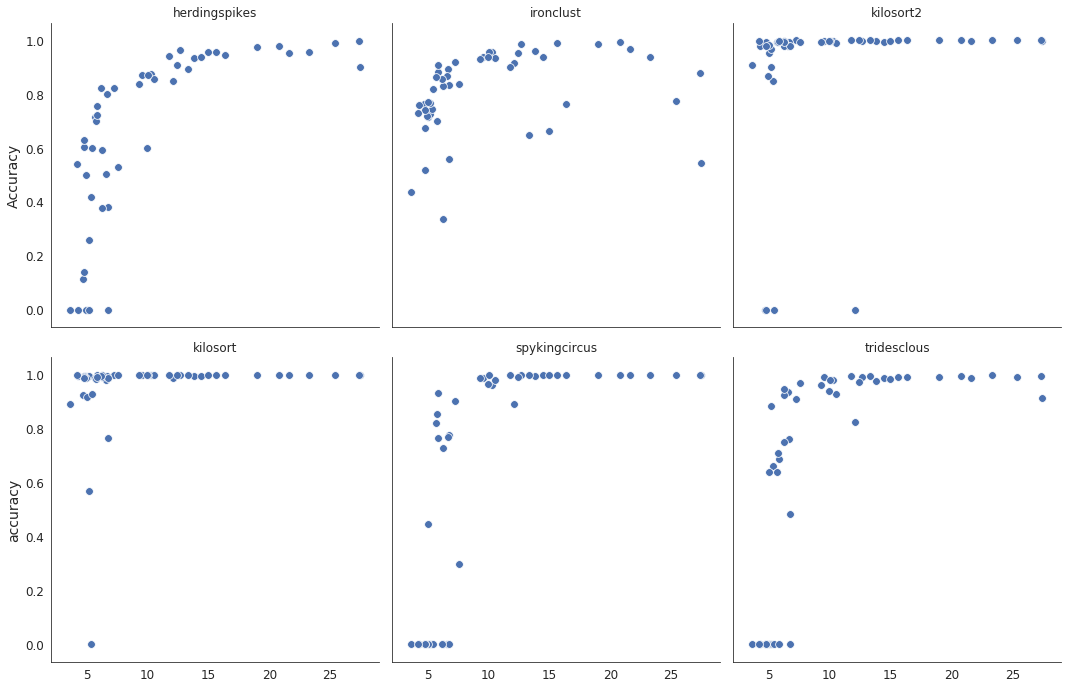

In [30]:
df = dataframes['perf_by_units']


# add snr to the by-unit table
df['snr'] = None
for gt_id in snr.index:
    df['snr'].loc[df['gt_unit_id']==gt_id] = snr.at[gt_id, 'snr']
df



sns.set_palette(sns.color_palette("deep"))
g = sns.relplot(data=dataframes['perf_by_units'], x='snr', y='accuracy', col='sorter_name', 
                col_wrap=3, col_order=sorter_list, s=60)
for i,ax in enumerate(g.axes):
    ax.set_title(sorter_list[i])
    ax.set_xlabel('')

    g.axes[0].set_xlabel('SNR');

g.axes[0].set_ylabel('Accuracy');